In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import warp, AffineTransform
from numpy import pad
from skimage import io
from PIL import Image
import torch

In [ ]:
def generate_strain_tensors():
    strain_xx = np.linspace(-0.5, -0.75, 1.5, 2)  # Stretching values
    strain_yy = np.linspace(-0.5, -0.75, 1.5, 2)  # Stretching values
    # shear_xy1 = np.linspace(-0.9, -0.5, 2)   # Shear strain
    # shear_xy2 = np.linspace(0.5, 0.9, 2)   # Shear strain
    shear_xy = np.linspace(-0.8, 0.8, 4)
    tensors = [
        (xx, yy, xy)
        for xx in strain_xx
        for yy in strain_yy
        for xy in shear_xy
    ]
    return tensors

In [ ]:
# Perform polar decomposition
def polar_decomposition(F):
    U, S, Vt = np.linalg.svd(F)
    R = U @ Vt  # Rotation matrix
    U_stretch = Vt.T @ np.diag(S) @ Vt  # Pure strain component
    return R, U_stretch

# Create deformation gradient from strain tensor
def deformation_gradient_from_strain(strain_tensor):
    F = np.eye(2) + strain_tensor
    return F

# Apply transformation
def apply_corotated_strain(image, s):

    strain_tensor = np.array([[s[0], s[2]], 
                              [s[2], s[1]]])
    F = deformation_gradient_from_strain(strain_tensor)

    R, F_strain = polar_decomposition(F)

    # Build affine transform matrix (add homogeneous coordinates)
    F_strain_h = np.eye(3)
    F_strain_h[:2, :2] = F_strain

    # Center image for proper transformation
    center = np.array(image.shape) / 2
    translation_to_origin = np.eye(3)
    translation_to_origin[:2, 2] = -center

    translation_back = np.eye(3)
    translation_back[:2, 2] = center

    # Combine transformations
    affine_matrix = translation_back @ F_strain_h @ translation_to_origin
    transform = AffineTransform(matrix=affine_matrix)

    # Apply warp
    transformed_image = warp(
        image,
        inverse_map=transform.inverse,
        mode="constant",
        cval=0.0,
        preserve_range=True,
        order=3  # Bicubic interpolation
    )
    return transformed_image

In [3]:
from DeDoDe import dedode_detector_L, dedode_descriptor_B
from DeDoDe.utils import get_best_device
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
device = get_best_device()
detector = dedode_detector_L(weights = torch.load("dedode_detector_L.pth", map_location = device))

/var/folders/7h/r85570js76dc_jxyvqndnt540000gn/T/ipykernel_25190/2625089703.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  detector = dedode_detector_L(weights = torch.

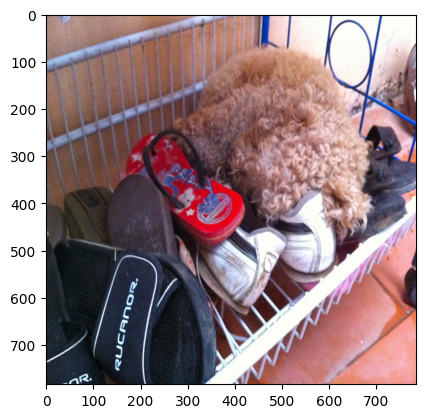

In [5]:
im_path = 'data/data/000000000042.jpg'
H = 784
W = 784
image = torch.from_numpy(np.array(Image.open(im_path).resize((W,H)))/255.).permute(2,0,1).float()
plt.imshow(image.permute(1, 2, 0))
plt.show()


In [6]:
print("PYTORCH_ENABLE_MPS_FALLBACK =", os.environ.get("PYTORCH_ENABLE_MPS_FALLBACK"))

PYTORCH_ENABLE_MPS_FALLBACK = 1


In [7]:
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
out = detector.detect_from_path(im_path, num_keypoints = 3)
W,H = Image.open(im_path).size
kps = out["keypoints"]
kps = detector.to_pixel_coords(kps, H, W)

/Users/constantinvonwitzleben/miniconda3/envs/stretchers/lib/python3.10/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


NotImplementedError: The operator 'aten::upsample_bicubic2d.out' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.